## Setting

### Optional

In [1]:
!pip install xgboost lightgbm catboost -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.1.1
    Uninstalling xgboost-3.1.1:
      Successfully uninstalled xgboost-3.1.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root = "/content/drive/MyDrive/Machine Learning/"
import sys
sys.path.append(root)

### Required

In [4]:
from close.train_tuning import Model
from close.evaluation import show_confusion_matrix, per_class_accuracy, overall_metrics, top_k_accuracy, confidence_analysis

is_binary = False

## Loading Data

In [5]:
import pickle
import pandas as pd

use_original_data = False

# Load the pickle file
print("Loading datafile...")
with open(f"{root}data/preprocess_data_33/close_train_33.pkl", "rb") as f:
    train = pickle.load(f)
    X_train = pd.DataFrame(train["X"])
    X_train.columns = train["feature_names"]
    y_train = train["y"]
with open(f"{root}data/preprocess_data_33/close_val_33.pkl", "rb") as f:
    val = pickle.load(f)
    X_val = pd.DataFrame(val["X"])
    X_val.columns = val["feature_names"]
    y_val = val["y"]

if use_original_data:
  X_train = train['scaler'].inverse_transform(train['X'])
  X_train = pd.DataFrame(X_train)
  X_train.columns = train['feature_names']

  X_val = val['scaler'].inverse_transform(val['X'])
  X_val = pd.DataFrame(X_val)
  X_val.columns = val['feature_names']

print("Loading complete.")
print("Training data size:\t", len(X_train))
print("Validation data size:\t", len(X_val))

Loading datafile...
Loading complete.
Training data size:	 13300
Validation data size:	 2850


## Model

knn

In [6]:
model_type = "knn"
param_grid = {
    "n_neighbors": [3, 5, 7],            # k 값
    "weights": ["uniform", "distance"],  # 가중치 방식
    "p": [1, 2],                         # 1: manhattan, 2: euclidean
}

### Base Model Training

In [7]:
# 1) knn으로 중요도 계산
mdl = Model(is_binary=is_binary, code="knn")
mdl.create_model("knn")
mdl.fit(X_train, y_train)

fi_sorted = mdl.get_feature_importances(X_test=X_val, y_test=y_val)
ranked_names = list(fi_sorted.keys())

# 2) top-k 피처 조합 생성
def make_feature_combinations(ranked_names, k_list):
    combos = []
    for k in k_list:
        combos.append({
            "k": k,
            "features": ranked_names[:k]
        })
    return combos

k_list = [24, 29, 33]
feature_combinations = make_feature_combinations(ranked_names, k_list)

print(feature_combinations)


[{'k': 24, 'features': ['burst_max_first30', 'duration', 'burst_std_first30', 'burst_ratio_in_first30', 'burst_mean', 'ratio_out', 'frac_in', 'burst_std', 'num_out', 'burst_ratio_in', 'switch_count', 'burst_count', 'num_in', 'n_packets', 'switch_count_first30', 'burst_count_first30', 'burst_mean_first30', 'burst_max', 'q75_iat_first30', 'std_iat', 'in_first30', 'out_first30', 'ratio_out_first30', 'frac_in_first30']}, {'k': 29, 'features': ['burst_max_first30', 'duration', 'burst_std_first30', 'burst_ratio_in_first30', 'burst_mean', 'ratio_out', 'frac_in', 'burst_std', 'num_out', 'burst_ratio_in', 'switch_count', 'burst_count', 'num_in', 'n_packets', 'switch_count_first30', 'burst_count_first30', 'burst_mean_first30', 'burst_max', 'q75_iat_first30', 'std_iat', 'in_first30', 'out_first30', 'ratio_out_first30', 'frac_in_first30', 'q75_iat', 'median_iat_first30', 'mean_iat', 'mean_iat_first30', 'duration_first30']}, {'k': 33, 'features': ['burst_max_first30', 'duration', 'burst_std_first30

In [8]:
import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

results = []

for comb in feature_combinations:        # e.g. k=,24,29,33
    k = comb["k"]
    feat_names = comb["features"]

    print(f"\n====== Testing feature subset: k={k} ======")
    print("Features:", feat_names)

    # 1) 조합에 맞게 subset 생성
    X_train_sub = X_train[feat_names]
    X_val_sub   = X_val[feat_names]

    # 2) 모델 생성 (baseline hyperparameters 사용)
    model = Model(is_binary=is_binary)
    model.create_model(model_type)      # <-- baseline default hparams 자동 적용
    print("Using baseline hparams:", model.hparams)

    # 3) 학습
    model.fit(X_train_sub, y_train)

    # 4) 성능 평가
    val_acc = model.score(X_val_sub, y_val)
    print(f"[k={k}] Val Accuracy = {val_acc:.4f}")

    # 5) K-Fold (train subset 기준)
    cv_scores = model.k_fold_cv(X_train_sub, y_train, k=5)

    # 6) 결과 저장
    results.append({
        "k": k,
        "features": feat_names,
        "val_acc": val_acc,
        "cv_mean": np.mean(cv_scores),
        "cv_scores": cv_scores.tolist(),
    })

# 7) 전체 결과 표로 확인
results_df = pd.DataFrame(results).sort_values(by="val_acc", ascending=False)
print("\n=== Summary (baseline hparams, feature subsets) ===")
print(results_df)



====== Testing feature subset: k=24 ======
Features: ['burst_max_first30', 'duration', 'burst_std_first30', 'burst_ratio_in_first30', 'burst_mean', 'ratio_out', 'frac_in', 'burst_std', 'num_out', 'burst_ratio_in', 'switch_count', 'burst_count', 'num_in', 'n_packets', 'switch_count_first30', 'burst_count_first30', 'burst_mean_first30', 'burst_max', 'q75_iat_first30', 'std_iat', 'in_first30', 'out_first30', 'ratio_out_first30', 'frac_in_first30']
Using baseline hparams: {'n_neighbors': 5, 'weights': 'uniform', 'p': 2}
[k=24] Val Accuracy = 0.7144
5-fold Cross Validation Scores:	[0.69210526 0.69511278 0.70300752 0.6924812  0.70789474]
5-fold Cross Validation Average Score:	0.6981203007518797

====== Testing feature subset: k=29 ======
Features: ['burst_max_first30', 'duration', 'burst_std_first30', 'burst_ratio_in_first30', 'burst_mean', 'ratio_out', 'frac_in', 'burst_std', 'num_out', 'burst_ratio_in', 'switch_count', 'burst_count', 'num_in', 'n_packets', 'switch_count_first30', 'burst_c

### Feature Evaluation

In [9]:
mdl.get_feature_importances(X_test=X_val, y_test=y_val)

{'burst_max_first30': np.float64(0.1869122807017544),
 'duration': np.float64(0.12364912280701754),
 'burst_std_first30': np.float64(0.09803508771929824),
 'burst_ratio_in_first30': np.float64(0.0971578947368421),
 'burst_mean': np.float64(0.07978947368421055),
 'ratio_out': np.float64(0.058561403508771925),
 'frac_in': np.float64(0.058561403508771925),
 'burst_std': np.float64(0.055087719298245595),
 'num_out': np.float64(0.054666666666666655),
 'burst_ratio_in': np.float64(0.0505263157894737),
 'switch_count': np.float64(0.04782456140350879),
 'burst_count': np.float64(0.04782456140350879),
 'num_in': np.float64(0.045157894736842105),
 'n_packets': np.float64(0.04133333333333333),
 'switch_count_first30': np.float64(0.037578947368421066),
 'burst_count_first30': np.float64(0.037578947368421066),
 'burst_mean_first30': np.float64(0.034350877192982465),
 'burst_max': np.float64(0.020526315789473715),
 'q75_iat_first30': np.float64(0.019438596491228068),
 'std_iat': np.float64(0.0184561

### Hyperparameter Tuning

In [10]:
import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)


# === k=24 조합만 추출 ===
comb_k = [c for c in feature_combinations if c["k"] == 24][0]
feat_names_24 = comb_k["features"]

print("=== GridSearch for k=24 ===")
print("Features:", feat_names_24)

# subset 생성
X_train_24 = X_train[feat_names_24]
X_val_24   = X_val[feat_names_24]

# 모델 생성
model_5 = Model(is_binary=False)
model_5.create_model("knn")

# GridSearchCV 실행
bst_24 = model_5.grid_search(X_train_24, y_train, param_grid, verbose=2)

best_model_24  = bst_24.best_estimator_
best_params_24 = bst_24.best_params_
best_cv_24     = bst_24.best_score_
val_acc_24     = best_model_24.score(X_val_24, y_val)


=== GridSearch for k=24 ===
Features: ['burst_max_first30', 'duration', 'burst_std_first30', 'burst_ratio_in_first30', 'burst_mean', 'ratio_out', 'frac_in', 'burst_std', 'num_out', 'burst_ratio_in', 'switch_count', 'burst_count', 'num_in', 'n_packets', 'switch_count_first30', 'burst_count_first30', 'burst_mean_first30', 'burst_max', 'q75_iat_first30', 'std_iat', 'in_first30', 'out_first30', 'ratio_out_first30', 'frac_in_first30']
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   1.3s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   1.2s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   0.9s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   0.9s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   0.9s
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=   0.9s
[CV] END ..........

In [11]:
import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

# === k=29 조합만 추출 ===
comb_k = [c for c in feature_combinations if c["k"] == 29][0]
feat_names_29 = comb_k["features"]

print("=== GridSearch for k=29 ===")
print("Features:", feat_names_29)

# subset 생성
X_train_29 = X_train[feat_names_29]
X_val_29   = X_val[feat_names_29]

# 모델 생성
model_5 = Model(is_binary=False)
model_5.create_model("knn")

# GridSearchCV 실행
bst_29 = model_5.grid_search(X_train_29, y_train, param_grid, verbose=2)

best_model_29  = bst_29.best_estimator_
best_params_29 = bst_29.best_params_
best_cv_29     = bst_29.best_score_
val_acc_29     = best_model_29.score(X_val_29, y_val)

=== GridSearch for k=29 ===
Features: ['burst_max_first30', 'duration', 'burst_std_first30', 'burst_ratio_in_first30', 'burst_mean', 'ratio_out', 'frac_in', 'burst_std', 'num_out', 'burst_ratio_in', 'switch_count', 'burst_count', 'num_in', 'n_packets', 'switch_count_first30', 'burst_count_first30', 'burst_mean_first30', 'burst_max', 'q75_iat_first30', 'std_iat', 'in_first30', 'out_first30', 'ratio_out_first30', 'frac_in_first30', 'q75_iat', 'median_iat_first30', 'mean_iat', 'mean_iat_first30', 'duration_first30']
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   1.0s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   1.0s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   1.0s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   1.1s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   1.5s
[CV] END ......

In [12]:
import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

# === k=33 조합만 추출 ===
comb_k33 = [c for c in feature_combinations if c["k"] == 33][0]
feat_names_33 = comb_k33["features"]

print("=== GridSearch for k=33 ===")
print("Features:", feat_names_33)

# subset 생성
X_train_33 = X_train[feat_names_33]
X_val_33   = X_val[feat_names_33]

# 모델 생성
model_33 = Model(is_binary=False)
model_33.create_model("knn")

# GridSearchCV 실행
bst_33 = model_33.grid_search(X_train_33, y_train, param_grid, verbose=2)

best_model_33    = bst_33.best_estimator_
best_params_33   = bst_33.best_params_
best_cv_33       = bst_33.best_score_
val_acc_33       = best_model_33.score(X_val_33, y_val)



=== GridSearch for k=33 ===
Features: ['burst_max_first30', 'duration', 'burst_std_first30', 'burst_ratio_in_first30', 'burst_mean', 'ratio_out', 'frac_in', 'burst_std', 'num_out', 'burst_ratio_in', 'switch_count', 'burst_count', 'num_in', 'n_packets', 'switch_count_first30', 'burst_count_first30', 'burst_mean_first30', 'burst_max', 'q75_iat_first30', 'std_iat', 'in_first30', 'out_first30', 'ratio_out_first30', 'frac_in_first30', 'q75_iat', 'median_iat_first30', 'mean_iat', 'mean_iat_first30', 'duration_first30', 'std_iat_first30', 'median_iat', 'q25_iat', 'q25_iat_first30']
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   1.1s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   1.2s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   1.1s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   1.6s
[CV] END ................n_neighb

### Evaluation

2. Per-class Accuracy



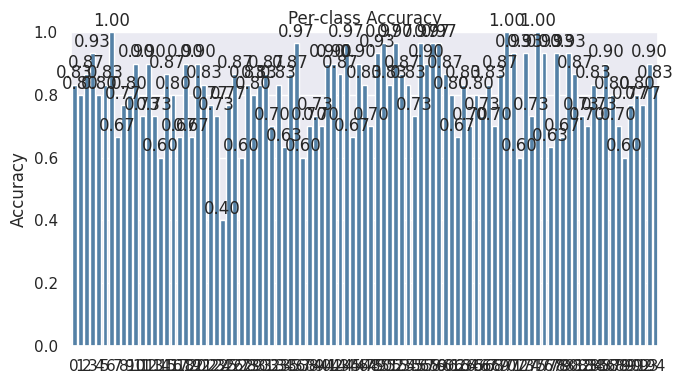

3. Overall Metrics

- Accuracy: 0.8074
- Macro F1: 0.8062 (macro P=0.8111, macro R=0.8074)
- Weighted F1: 0.8062 (weighted P=0.8111, weighted R=0.8074)
- Log Loss: 4.5440
4. Top k Accuracy

- Top-1 accuracy: 0.8074
- Top-3 accuracy: 0.8796
- Top-5 accuracy: 0.8821


<Figure size 640x480 with 0 Axes>

In [13]:
from sklearn.metrics import confusion_matrix

# 1) 최종 모델 및 데이터 준비
model_best = best_model_24
best_features = feat_names_24

X_val_best = X_val[best_features]
y = y_val
y_pred = model_best.predict(X_val_best)
y_prob = model_best.predict_proba(X_val_best)

# 2) 클래스 정보
n_classes = len(np.unique(y_train))
class_names = [str(i) for i in range(n_classes)]

# 2.5) confusion matrix 추가 (필수)
cm = confusion_matrix(y, y_pred)

# 3) metrics 호출
per_class_accuracy(cm, class_names, model_type)
overall_metrics(y, y_pred, y_prob, n_classes)
top_k_accuracy(y, y_prob, n_classes)


In [14]:
with open("best_knn_k24.pkl", "wb") as f:
    pickle.dump(best_model_24, f)

## Model

NN

In [15]:
param_grid = {
    "hidden_layer_sizes": [(64,), (128,), (128, 64)],
    "alpha": [0.0001, 0.001],
    "learning_rate_init": [0.001, 0.01],
    "max_iter": [300],
}


### Base Model Training

get feature importance and generate feature combinations

In [16]:
import numpy as np

# 1) wrapper 기반 nn 모델 생성 & 학습
mdl = Model(is_binary=is_binary, code="nn")
mdl.create_model("nn")
mdl.fit(X_train, y_train)

# 2) wrapper로 raw feature importance 받기 (NN 에는 반드시 val 데이터 필요!)
fi_raw = mdl.get_feature_importances(X_test=X_val, y_test=y_val)

# 3) wrapper가 반환한 feature 이름을 실제 DataFrame 컬럼명으로 매핑
mapped_fi = {}

for feat, imp in fi_raw.items():
    if feat.startswith("feature_"):
        idx = int(feat.split("_")[1])-1
        real_name = X_train.columns[idx]
        mapped_fi[real_name] = imp
    else:
        mapped_fi[feat] = imp

# 4) 중요도 정렬
fi_sorted = dict(
    sorted(mapped_fi.items(), key=lambda x: abs(x[1]), reverse=True)
)

print("=== [NN] Feature importances (name, importance) ===")
for name, value in fi_sorted.items():
    print(f"{name:15s}  {value}")

# 5) top-k feature 조합 생성
ranked_names = list(fi_sorted.keys())

def make_feature_combinations(ranked_names, k_list):
    combos = []
    for k in k_list:
        combos.append({
            "k": k,
            "features": ranked_names[:k]
        })
    return combos

k_list = [24, 29, 33]
feature_combinations = make_feature_combinations(ranked_names, k_list)

print("\n=== Generated feature combinations ===")
print(feature_combinations)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


=== [NN] Feature importances (name, importance) ===
burst_max_first30  0.4880701754385964
burst_std_first30  0.40884210526315784
burst_mean       0.3146315789473684
num_out          0.18414035087719297
duration         0.1814736842105263
ratio_out        0.16442105263157894
frac_in          0.1629473684210526
burst_std        0.15575438596491226
burst_mean_first30  0.14561403508771925
burst_count_first30  0.12957894736842102
switch_count_first30  0.1204210526315789
burst_count      0.1123508771929824
switch_count     0.10666666666666665
num_in           0.10101754385964905
burst_ratio_in   0.09873684210526312
burst_ratio_in_first30  0.09708771929824558
std_iat          0.09592982456140349
n_packets        0.09424561403508766
out_first30      0.05178947368421048
ratio_out_first30  0.04887719298245611
burst_max        0.045157894736842064
frac_in_first30  0.043859649122806973
in_first30       0.03950877192982449
mean_iat         0.038245614035087694
std_iat_first30  0.030736842105263118


basemodel training

In [17]:
import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

results = []

for comb in feature_combinations:        # e.g. k=24, 29 , 33
    k = comb["k"]
    feat_names = comb["features"]

    print(f"\n====== Testing feature subset: k={k} ======")
    print("Features:", feat_names)

    # 1) 조합에 맞게 subset 생성
    X_train_sub = X_train[feat_names]
    X_val_sub   = X_val[feat_names]

    # 2) 모델 생성 (baseline hyperparameters 사용)
    model = Model(is_binary=is_binary)
    model.create_model(model_type)      # <-- baseline default hparams 자동 적용
    print("Using baseline hparams:", model.hparams)

    # 3) 학습
    model.fit(X_train_sub, y_train)

    # 4) 성능 평가
    val_acc = model.score(X_val_sub, y_val)
    print(f"[k={k}] Val Accuracy = {val_acc:.4f}")

    # 5) K-Fold (train subset 기준)
    cv_scores = model.k_fold_cv(X_train_sub, y_train, k=5)

    # 6) 결과 저장
    results.append({
        "k": k,
        "features": feat_names,
        "val_acc": val_acc,
        "cv_mean": np.mean(cv_scores),
        "cv_scores": cv_scores.tolist(),
    })

# 7) 전체 결과 표로 확인
results_df = pd.DataFrame(results).sort_values(by="val_acc", ascending=False)
print("\n=== Summary (baseline hparams, feature subsets) ===")
print(results_df)



====== Testing feature subset: k=24 ======
Features: ['burst_max_first30', 'burst_std_first30', 'burst_mean', 'num_out', 'duration', 'ratio_out', 'frac_in', 'burst_std', 'burst_mean_first30', 'burst_count_first30', 'switch_count_first30', 'burst_count', 'switch_count', 'num_in', 'burst_ratio_in', 'burst_ratio_in_first30', 'std_iat', 'n_packets', 'out_first30', 'ratio_out_first30', 'burst_max', 'frac_in_first30', 'in_first30', 'mean_iat']
Using baseline hparams: {'n_neighbors': 5, 'weights': 'uniform', 'p': 2}
[k=24] Val Accuracy = 0.7312
5-fold Cross Validation Scores:	[0.71729323 0.71766917 0.72819549 0.72518797 0.72932331]
5-fold Cross Validation Average Score:	0.7235338345864661

====== Testing feature subset: k=29 ======
Features: ['burst_max_first30', 'burst_std_first30', 'burst_mean', 'num_out', 'duration', 'ratio_out', 'frac_in', 'burst_std', 'burst_mean_first30', 'burst_count_first30', 'switch_count_first30', 'burst_count', 'switch_count', 'num_in', 'burst_ratio_in', 'burst_ra

### Feature Evaluation

In [18]:
mdl.get_feature_importances(X_test=X_val, y_test=y_val)

{'burst_max_first30': np.float64(0.4880701754385964),
 'burst_std_first30': np.float64(0.40884210526315784),
 'burst_mean': np.float64(0.3146315789473684),
 'num_out': np.float64(0.18414035087719297),
 'duration': np.float64(0.1814736842105263),
 'ratio_out': np.float64(0.16442105263157894),
 'frac_in': np.float64(0.1629473684210526),
 'burst_std': np.float64(0.15575438596491226),
 'burst_mean_first30': np.float64(0.14561403508771925),
 'burst_count_first30': np.float64(0.12957894736842102),
 'switch_count_first30': np.float64(0.1204210526315789),
 'burst_count': np.float64(0.1123508771929824),
 'switch_count': np.float64(0.10666666666666665),
 'num_in': np.float64(0.10101754385964905),
 'burst_ratio_in': np.float64(0.09873684210526312),
 'burst_ratio_in_first30': np.float64(0.09708771929824558),
 'std_iat': np.float64(0.09592982456140349),
 'n_packets': np.float64(0.09424561403508766),
 'out_first30': np.float64(0.05178947368421048),
 'ratio_out_first30': np.float64(0.0488771929824561

### Hyperparameter Tuning

In [19]:
import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

# === k=24 조합만 추출 ===
comb_k24 = [c for c in feature_combinations if c["k"] == 24][0]
feat_names_24 = comb_k24["features"]

print("=== GridSearch for k=24 ===")
print("Features:", feat_names_24)

# subset 생성
X_train_24 = X_train[feat_names_24]
X_val_24   = X_val[feat_names_24]

# 모델 생성
model_24 = Model(is_binary=False)
model_24.create_model("nn")

# GridSearchCV 실행
bst_24 = model_24.grid_search(X_train_24, y_train, param_grid, verbose=2)

best_model_24    = bst_24.best_estimator_
best_params_24   = bst_24.best_params_
best_cv_24       = bst_24.best_score_
val_acc_24       = best_model_24.score(X_val_24, y_val)

print("\n=== Result (k=24) ===")
print("best_cv_score:", best_cv_24)
print("val_acc      :", val_acc_24)
print("best_params  :", best_params_24)

=== GridSearch for k=24 ===
Features: ['burst_max_first30', 'burst_std_first30', 'burst_mean', 'num_out', 'duration', 'ratio_out', 'frac_in', 'burst_std', 'burst_mean_first30', 'burst_count_first30', 'switch_count_first30', 'burst_count', 'switch_count', 'num_in', 'burst_ratio_in', 'burst_ratio_in_first30', 'std_iat', 'n_packets', 'out_first30', 'ratio_out_first30', 'burst_max', 'frac_in_first30', 'in_first30', 'mean_iat']
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  30.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  29.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  30.7s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  35.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  32.1s
[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  14.8s
[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  26.6s
[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  17.2s
[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  24.0s
[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  20.6s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  52.5s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  50.4s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  51.5s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  51.0s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  48.3s
[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  27.3s
[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  19.9s
[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  20.4s
[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  17.6s
[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  20.8s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  53.6s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  54.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  54.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  54.0s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  52.4s
[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=   9.5s
[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  13.4s
[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  11.3s
[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  11.0s
[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  18.6s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  28.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  28.6s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  27.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  29.7s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  30.7s
[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  18.7s
[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  18.2s
[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  15.4s
[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  22.2s
[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  18.7s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  44.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  46.4s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  44.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  46.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  43.9s
[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  19.0s
[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  22.1s
[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  13.4s
[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  24.6s
[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  18.4s
[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  54.0s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  53.4s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  53.2s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  51.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  53.9s
[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  24.4s
[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  18.8s
[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  15.8s
[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  12.8s
[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  13.9s
Model type:	Neural Network (MLP) Model
Best score:	0.8011278195488722
Best parameters:	{'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001, 'max_iter': 300}
Best estimator:	MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42)

=== Result (k=24) ===
best_cv_score: 0.8011278195488722
val_acc

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [20]:
import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

# === k=29 조합만 추출 ===
comb_k29 = [c for c in feature_combinations if c["k"] == 29][0]
feat_names_29 = comb_k29["features"]

print("=== GridSearch for k=29 ===")
print("Features:", feat_names_29)

# subset 생성
X_train_29 = X_train[feat_names_29]
X_val_29   = X_val[feat_names_29]

# 모델 생성
model_29 = Model(is_binary=False)
model_29.create_model("nn")

# GridSearchCV 실행
bst_29 = model_29.grid_search(X_train_29, y_train, param_grid, verbose=2)

best_model_29    = bst_29.best_estimator_
best_params_29   = bst_29.best_params_
best_cv_29       = bst_29.best_score_
val_acc_29       = best_model_29.score(X_val_29, y_val)

print("\n=== Result (k=29) ===")
print("best_cv_score:", best_cv_29)
print("val_acc      :", val_acc_29)
print("best_params  :", best_params_29)


=== GridSearch for k=29 ===
Features: ['burst_max_first30', 'burst_std_first30', 'burst_mean', 'num_out', 'duration', 'ratio_out', 'frac_in', 'burst_std', 'burst_mean_first30', 'burst_count_first30', 'switch_count_first30', 'burst_count', 'switch_count', 'num_in', 'burst_ratio_in', 'burst_ratio_in_first30', 'std_iat', 'n_packets', 'out_first30', 'ratio_out_first30', 'burst_max', 'frac_in_first30', 'in_first30', 'mean_iat', 'std_iat_first30', 'q75_iat_first30', 'mean_iat_first30', 'duration_first30', 'q75_iat']
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  29.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  29.6s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  30.2s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  37.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  30.3s
[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  20.2s
[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  24.6s
[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  11.4s
[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  17.9s
[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  16.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  50.6s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  46.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  51.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  53.0s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  46.5s
[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  13.5s
[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  22.4s
[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  21.2s
[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  16.2s
[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  17.4s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  53.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  54.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  54.8s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  53.6s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  54.5s
[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  13.3s
[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  12.8s
[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=   8.7s
[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  11.8s
[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  18.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  30.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  29.8s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  28.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  28.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  28.5s
[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  17.9s
[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  11.9s
[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  11.3s
[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  14.9s
[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  14.0s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  44.2s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  44.4s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  45.0s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  47.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  43.6s
[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  12.9s
[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  17.4s
[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  14.8s
[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  23.8s
[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  15.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  54.8s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  52.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  54.5s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  55.0s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  53.8s
[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  14.4s
[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  18.2s
[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  12.3s
[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  14.2s
[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  15.3s
Model type:	Neural Network (MLP) Model
Best score:	0.7917293233082707
Best parameters:	{'alpha': 0.001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001, 'max_iter': 300}
Best estimator:	MLPClassifier(alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=300,
              random_state=42)

=== Result (k=29) ===
best_cv_score: 

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [21]:
import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

# === k=33 조합만 추출 ===
comb_k33 = [c for c in feature_combinations if c["k"] == 33][0]
feat_names_33 = comb_k33["features"]

print("=== GridSearch for k=33 ===")
print("Features:", feat_names_33)

# subset 생성
X_train_33 = X_train[feat_names_33]
X_val_33   = X_val[feat_names_33]

# 모델 생성
model_33 = Model(is_binary=False)
model_33.create_model("nn")

# GridSearchCV 실행
bst_33 = model_33.grid_search(X_train_33, y_train, param_grid, verbose=2)

best_model_33    = bst_33.best_estimator_
best_params_33   = bst_33.best_params_
best_cv_33       = bst_33.best_score_
val_acc_33       = best_model_33.score(X_val_33, y_val)

print("\n=== Result (k=33) ===")
print("best_cv_score:", best_cv_33)
print("val_acc      :", val_acc_33)
print("best_params  :", best_params_33)


=== GridSearch for k=33 ===
Features: ['burst_max_first30', 'burst_std_first30', 'burst_mean', 'num_out', 'duration', 'ratio_out', 'frac_in', 'burst_std', 'burst_mean_first30', 'burst_count_first30', 'switch_count_first30', 'burst_count', 'switch_count', 'num_in', 'burst_ratio_in', 'burst_ratio_in_first30', 'std_iat', 'n_packets', 'out_first30', 'ratio_out_first30', 'burst_max', 'frac_in_first30', 'in_first30', 'mean_iat', 'std_iat_first30', 'q75_iat_first30', 'mean_iat_first30', 'duration_first30', 'q75_iat', 'median_iat_first30', 'median_iat', 'q25_iat', 'q25_iat_first30']
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  29.5s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  30.7s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  31.0s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  29.2s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  28.8s
[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  28.1s
[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  14.0s
[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  14.9s
[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  19.7s
[CV] END alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  24.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  45.7s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  48.6s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  45.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  45.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  48.3s
[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  17.3s
[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  18.2s
[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  19.0s
[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  19.3s
[CV] END alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  15.7s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  54.5s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  55.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  54.2s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  53.2s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  53.1s
[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=   9.7s
[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  14.2s
[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=   8.8s
[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  18.2s
[CV] END alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  12.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  28.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  28.7s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  28.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  27.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.001, max_iter=300; total time=  28.0s
[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  14.8s
[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  20.4s
[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=   8.6s
[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  18.5s
[CV] END alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.01, max_iter=300; total time=  13.7s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  43.8s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  42.8s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  42.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  42.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.001, max_iter=300; total time=  41.6s
[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  15.8s
[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  17.8s
[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  15.3s
[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  12.5s
[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.01, max_iter=300; total time=  25.4s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  53.2s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  54.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  50.0s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  52.5s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300; total time=  53.2s
[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  14.6s
[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  12.1s
[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  17.9s
[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=   9.7s
[CV] END alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=300; total time=  15.0s
Model type:	Neural Network (MLP) Model
Best score:	0.7884962406015038
Best parameters:	{'alpha': 0.001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001, 'max_iter': 300}
Best estimator:	MLPClassifier(alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=300,
              random_state=42)

=== Result (k=33) ===
best_cv_score: 

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


### Evaluation

2. Per-class Accuracy



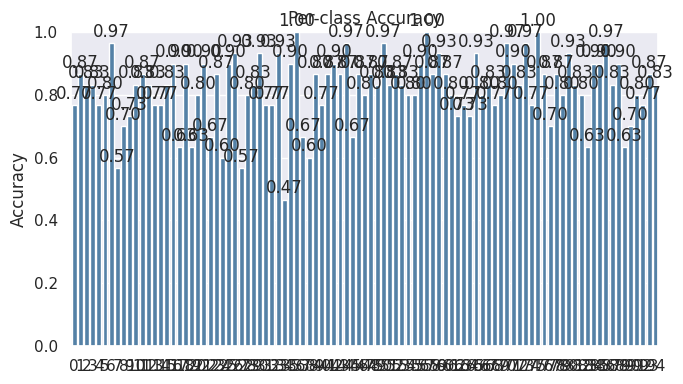

3. Overall Metrics

- Accuracy: 0.8186
- Macro F1: 0.8181 (macro P=0.8244, macro R=0.8186)
- Weighted F1: 0.8181 (weighted P=0.8244, weighted R=0.8186)
- Log Loss: 1.0095
4. Top k Accuracy

- Top-1 accuracy: 0.8186
- Top-3 accuracy: 0.9246
- Top-5 accuracy: 0.9526


<Figure size 640x480 with 0 Axes>

In [24]:
from sklearn.metrics import confusion_matrix

# 1) 최종 모델 및 데이터 준비
model_best = best_model_24
best_features = feat_names_24

X_val_best = X_val[best_features]
y = y_val
y_pred = model_best.predict(X_val_best)
y_prob = model_best.predict_proba(X_val_best)

# 2) 클래스 정보
n_classes = len(np.unique(y_train))
class_names = [str(i) for i in range(n_classes)]

# 2.5) confusion matrix 추가 (필수)
cm = confusion_matrix(y, y_pred)

# 3) metrics 호출
per_class_accuracy(cm, class_names, model_type)
overall_metrics(y, y_pred, y_prob, n_classes)
top_k_accuracy(y, y_prob, n_classes)


In [25]:
with open("best_nn_k24.pkl", "wb") as f:
    pickle.dump(best_model_24, f)